# GALAH DR4 Spectrum Analysis assuming Single Source

This script is used to find the optimal set of stellar labels for GALAH spectra in combination with non-spectroscopic information

The code is maintained at
https://github.com/svenbuder/GALAH_DR4
and described at
https://github.com/svenbuder/galah_dr4_paper

Author(s): Sven Buder (ANU, ASTRO 3D)

History:  
220902 Created from previous code 'galah_dr4_spectrum_analysis_simple'

In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    %config Completer.use_jedi = False
except:
    pass

import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
import sys
import os
from pathlib import Path
from astropy.io import fits
# import pickle
# import scipy.interpolate
# from scipy import signal
# from scipy.spatial import cKDTree
# import scipy.optimize as op
# from scipy.ndimage.filters import convolve
# from scipy.io import readsav
# from scipy.optimize import curve_fit
# import emcee
# import corner

In [2]:
start_time = time.time()

In [3]:
galah_dr4_directory = os.path.abspath(os.getcwd()+'/../')+'/'

In [41]:
repeat_table = Table.read(galah_dr4_directory+'observations/dr6.0_220714_repeats.fits')
init_values_table = Table.read('galah_dr4_initial_parameters_220714_lite.fits')

In [90]:
if sys.argv[1] != '-f':
    tmass_id = str(sys.argv[1])
else:
    tmass_id = '04060261-6430120' # Random star with Teff/logg/fe_h 6000 3.5 -0.25
#     tmass_id = '13280077-4732469' # OmegaCen star
#     tmass_id = '13280245-4738255' # OmegaCen star

In [91]:
spectrum = dict()
spectrum['tmass_id'] = tmass_id

spectrum['sobject_ids'] = list(repeat_table['sobject_id'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0]])
spectrum['sobject_ids'].sort()
spectrum['mjds'] = np.array(repeat_table['mjd'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0]],dtype=float)

spectrum['sobject_id'] = spectrum['sobject_ids'][0] + 1000
spectrum['rv_gaia_dr3'] = float(repeat_table['radial_velocity'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0][0]])
spectrum['e_rv_gaia_dr3'] = float(repeat_table['radial_velocity_error'][np.where(repeat_table['tmass_id'] == spectrum['tmass_id'])[0][0]])


# Read in single star analysis results

In [149]:
single_results = dict()
single_results['sobject_id'] = []
single_results['rv_gauss'] = []
single_results['e_rv_gauss'] = []
single_results['mjd'] = []
single_results['flag_sp_fit'] = []
single_results['teff'] = []
single_results['logg'] = []
single_results['fe_h'] = []
single_results['vmic'] = []
single_results['vsini'] = []
single_results['e_vsini'] = []

for sobject_id,mjd in zip(spectrum['sobject_ids'],spectrum['mjds']):
    try:
        results = Table.read(galah_dr4_directory+'analysis_products/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_single_fit_results.fits')
        single_results['sobject_id'].append(sobject_id)
        single_results['rv_gauss'].append(results['rv_gauss'][0])
        single_results['e_rv_gauss'].append(results['e_rv_gauss'][0])
        single_results['mjd'].append(mjd)
        single_results['flag_sp_fit'].append(results['flag_sp_fit'][0])
        single_results['teff'].append(results['teff'][0])
        single_results['logg'].append(results['logg'][0])
        single_results['fe_h'].append(results['fe_h'][0])
        single_results['vmic'].append(results['vmic'][0])
        single_results['vsini'].append(results['vsini'][0])
        single_results['e_vsini'].append(results['cov_e_vsini'][0])
        print('Read in '+str(sobject_id))
    except:
        print('Could not read in '+str(sobject_id))
        pass
    
for label in ['rv_gauss','e_rv_gauss','mjd','flag_sp_fit','teff','logg','fe_h','vmic','vsini','e_vsini']:
    single_results[label] = np.array(single_results[label])

Read in 161213001601109
Read in 161219001601108
Read in 170107001601107
Read in 170908003401108
Read in 170910005601108
Read in 171206001601108
Read in 171207001601108
Read in 171230001601335


# Setup our output data

In [150]:
output = Table()
file_directory = galah_dr4_directory+'analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

col = Table.Column(
    name='sobject_id',
    data = [spectrum['sobject_id']],
    description='GALAH unique identifier; spectrum stacked via tmass_id',
    unit='')
output.add_column(col)
col = Table.Column(
    name='tmass_id',
    data = [spectrum['tmass_id']],
    description='2MASS ID (same for stacked spectra)',
    unit='')
output.add_column(col)

# Get our initial information

In [151]:
spectrum['flag_sp'] = int(0)
flag_sp_closest_3x3x3_model_not_available = int(1)
flag_sp_closest_extra6_model_not_available = int(2)
flag_sp_no_successful_convergence_within_maximum_loops = int(4)
flag_sp_not_all_ccds_available = int(8)

In [152]:
unflagged_single_measurements = (single_results['flag_sp_fit'] == 0)
len_unflagged = len(single_results['flag_sp_fit'][unflagged_single_measurements])

available_single_measurements = (single_results['flag_sp_fit'] < 128)
len_available = len(single_results['flag_sp_fit'][available_single_measurements])

if len_unflagged > 0:
    print(str(len_unflagged)+' unflagged single measurement(s) available. Will use their median as starting values.')
    use_for_starting_values = unflagged_single_measurements
else:
    if len_available > 0:
        print('No unflagged single measurement(s) available, but '+str(len_available)+' flagged ones. Will use their median as starting values.')
        use_for_starting_values = available_single_measurements
    else:
        raise ValueError('No measurements available at all!')
        
rv_mean,rv_sigma = (np.mean(single_results['rv_gauss'][use_for_starting_values]),np.std(single_results['rv_gauss'][use_for_starting_values]))
print(rv_mean,rv_sigma)

8 unflagged single measurement(s) available. Will use their median as starting values.
7.9824142 1.5894837


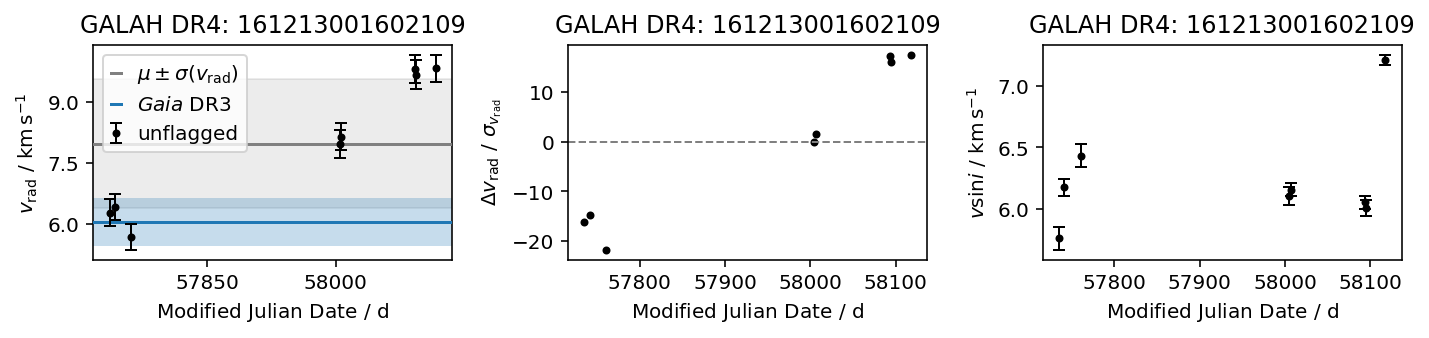

In [156]:
f, gs = plt.subplots(1,3,figsize=(10,2.5))

ax = gs[0]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))
if np.isfinite(rv_mean):
    ax.axhspan(
        rv_mean - rv_sigma,
        rv_mean + rv_sigma,
        alpha=0.15,zorder=1,color='grey'
    )
    ax.axhline(
        rv_mean,zorder=3,color='grey',label=r'$\mu \pm \sigma(v_\mathrm{rad})$'
    )
    
if np.isfinite(spectrum['rv_gaia_dr3']):
    ax.axhspan(
        spectrum['rv_gaia_dr3']-spectrum['e_rv_gaia_dr3'],
        spectrum['rv_gaia_dr3']+spectrum['e_rv_gaia_dr3'],
        alpha=0.25,zorder=2
    )
    ax.axhline(
        spectrum['rv_gaia_dr3'],zorder=4,label='$Gaia$ DR3'
    )

if (len_available > 0) & (len_available != len_unflagged):
    ax.errorbar(
        single_results['mjd'][available_single_measurements],
        single_results['rv_gauss'][available_single_measurements],
        yerr = 10*np.array(single_results['e_rv_gauss'][available_single_measurements]),
        ms=3,c='grey',capsize=3,lw=1,
        fmt='o',zorder=5,label='flagged'
    )
if len_unflagged > 0:
    ax.errorbar(
        single_results['mjd'][unflagged_single_measurements],
        single_results['rv_gauss'][unflagged_single_measurements],
        yerr = 10*np.array(single_results['e_rv_gauss'][unflagged_single_measurements]),
        ms=3,c='k',capsize=3,lw=1,
        fmt='o',zorder=6,label='unflagged'
    )
ax.legend(handlelength=0.5)
ax.yaxis.set_major_locator(MaxNLocator(4)) 
ax.xaxis.set_major_locator(MaxNLocator(4)) 
ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')

ax = gs[1]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))

ax.axhline(c='grey',lw=1,ls='dashed')
if (len_available > 0) & (len_available != len_unflagged):
    ax.scatter(
        single_results['mjd'][available_single_measurements],
        # (single_results['rv_gauss'][available_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][available_single_measurements]**2 + rv_sigma**2)
        (single_results['rv_gauss'][available_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][available_single_measurements]**2 + 0.1**2),
        c='grey',s=9
    )
if len_unflagged > 0:
    ax.scatter(
        single_results['mjd'][unflagged_single_measurements],
        # (single_results['rv_gauss'][unflagged_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][unflagged_single_measurements]**2 + rv_sigma**2)
        (single_results['rv_gauss'][unflagged_single_measurements] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][unflagged_single_measurements]**2 + 0.1**2),
        c='k',s=9
    )

ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\sigma_{v_\mathrm{rad}}$')

ax = gs[2]
ax.set_title('GALAH DR4: '+str(spectrum['sobject_id']))

if (len_available > 0) & (len_available != len_unflagged):
    ax.errorbar(
        single_results['mjd'][available_single_measurements],
        single_results['vsini'][available_single_measurements],
        yerr=single_results['e_vsini'][available_single_measurements],
        ms=3,c='grey',capsize=3,lw=1,
        fmt='o',zorder=5,label='flagged'
    )
if len_unflagged > 0:
    ax.errorbar(
        single_results['mjd'][unflagged_single_measurements],
        single_results['vsini'][unflagged_single_measurements],
        yerr=single_results['e_vsini'][unflagged_single_measurements],
        ms=3,c='k',capsize=3,lw=1,
        fmt='o',zorder=6,label='unflagged'
    )

ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$v \sin i~/~\mathrm{km\,s^{-1}}$')

single_results['vsini']

plt.tight_layout()
plt.savefig(file_directory+str(spectrum['sobject_id'])+'_stacked_rv_comparison.png',bbox_inches='tight')

In [157]:
print("ADD GAIA DR3 RUWE! - thanks Maddie")

ADD GAIA DR3 RUWE! - thanks Maddie


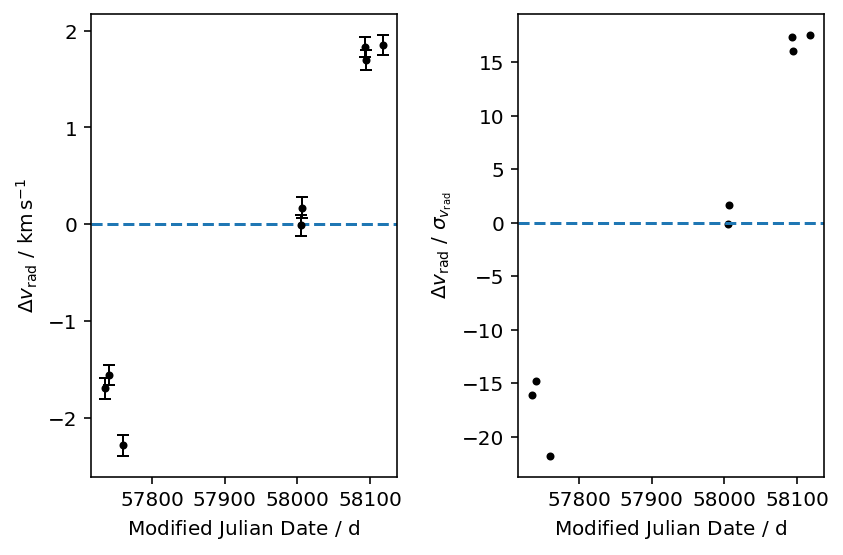

In [124]:
f, gs = plt.subplots(1,2)
ax = gs[0]
ax.axhline(0,color='C0',ls='dashed')

ax.errorbar(
    single_results['mjd'][unflagged_single_measurements],
    (single_results['rv_gauss'][use_for_starting_values] - rv_mean),
    # yerr = np.sqrt(single_results['e_rv_gauss'][use_for_starting_values]**2 + rv_sigma**2),
    yerr = np.sqrt(single_results['e_rv_gauss'][use_for_starting_values]**2 + 0.1**2),
    ms=3,c='k',capsize=3,lw=1,
    fmt='o',zorder=3
)
ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')


ax = gs[1]
ax.axhline(0,color='C0',ls='dashed')

ax.scatter(
    single_results['mjd'][unflagged_single_measurements],
    # (single_results['rv_gauss'][use_for_starting_values] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][use_for_starting_values]**2 + rv_sigma**2)
    (single_results['rv_gauss'][use_for_starting_values] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][use_for_starting_values]**2 + 0.1**2),
    c='k',s=9
)
ax.set_xlabel(r'$\mathrm{Modified~Julian~Date}~/~\mathrm{d}$')
ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\sigma_{v_\mathrm{rad}}$')

plt.tight_layout()


In [108]:
np.abs(single_results['rv_gauss'][use_for_starting_values] - rv_mean) / np.sqrt(single_results['e_rv_gauss'][use_for_starting_values]**2 + rv_sigma**2)

array([1.0673519 , 0.97845143, 1.4379143 , 0.0075312 , 0.10826799,
       1.1529504 , 1.0654854 , 1.1644627 ], dtype=float32)

In [97]:
print("IMPLEMENT HERE WHAT HAPPENS IF RV MEASUREMENTS DEVIATE FROM EACH OTHER, INDICATING RV BINARY")

IMPLEMENT HERE WHAT HAPPENS IF RV MEASUREMENTS DEVIATE FROM EACH OTHER, INDICATING RV BINARY


In [ ]:
spectrum['init_vrad'] = np.median(single_results['rv_gauss'][use_for_starting_values])
for label in ['teff','logg','fe_h','vmic','vsini']:
    spectrum['init_'+label] = np.median(single_results[label][use_for_starting_values])
    if label == 'teff':
        spectrum['init_'+label] /= 1000.
        
print('Initial values:')
print('RV = '+"{:.2f}".format(spectrum['init_vrad'])+' (Gaia DR3: '+"{:.2f}".format(spectrum['rv_gaia_dr3'])+')')
print('Teff, logg, fe_h, vmic, vsini')
print(str(int(1000*spectrum['init_teff']))+', '+"{:.2f}".format(spectrum['init_logg'])+', '+"{:.2f}".format(spectrum['init_fe_h'])+', '+"{:.2f}".format(spectrum['init_vmic'])+', '+"{:.2f}".format(spectrum['init_vsini']))
print()

for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    spectrum['init_'+element.lower()+'_fe'] = 0.0
    
alpha_fe = np.max([0.0,np.min([0.4,-0.4*spectrum['init_fe_h']])])
for each_alpha in ['o','mg','si','ca','ti']:
    spectrum['init_'+each_alpha+'_fe'] = alpha_fe
if sys.argv[1] == '-f': print('Enhancing [X/Fe] to '+"{:.2f}".format(alpha_fe)+' based on [Fe/H] for O, Mg, Si, Ca, and Ti ▔\▁')

# Read each spectrum

In [54]:
def read_spectrum(sobject_id, spectrum, init_values_table, neglect_ir_beginning=True):

    fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        print('Warning: Spectrum is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'

    if fits_file[0].header['WAV_OK']==0:
        print('Warning: Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        print('Warning: Cross-talk not calculated reliably!')

    spectrum['plate'] = int(fits_file[0].header['PLATE'])
    
    # This is a test if the CCD is actually available. For 181221001601377, CCD4 is missing for example.
    # We therefore implement a keyword 'available_ccds' to trigger only to loop over the available CCDs
    spectrum['available_ccds'] = []
    
    for ccd in [1,2,3,4]:
        
        try:

            if ccd != 1:
                fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

            spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
            spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

            spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
            counts_relative_uncertainty = fits_file[2].data

            bad_counts_unc = np.where(~(counts_relative_uncertainty > 0) == True)[0]
            if len(bad_counts_unc) > 0:
                if sys.argv[1] == '-f': print('Relative counts uncertainties <= 0 detected for '+str(len(bad_counts_unc))+' pixels in CCD'+str(ccd)+', setting to 0.1 (SNR~10)')
                counts_relative_uncertainty[bad_counts_unc] = 0.1

            spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * fits_file[0].data

            spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
            spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

            spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
            spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

            spectrum['available_ccds'].append(ccd)
        except:
            pass

        if ccd in spectrum['available_ccds']:
            if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:

                # find all spectra are
                # a) observed with same FIBRE (*pivot*) and
                # b) observed with the same PLATE (*plate*) 
                # c) have a measured LSF in the particular CCD
                # d) have the same resolution setup (low- or high-res)
                if spectrum['resolution'] != 'high-res':
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] < 262144)
                        )==True)[0]
                else:
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] >= 262144)
                        )==True)[0]

                # Difference between observing runs == abs(sobject_id - all possible sobject_ids)
                sobject_id_differences = np.abs(spectrum['sobject_id'] - init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile])
                # Now find the closest observing run
                closest_valid_sobject_id_index = np.argmin(sobject_id_differences)
                closest_valid_sobject_id = init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile][closest_valid_sobject_id_index]

                lsf_replacement_fits_file = fits.open(galah_dr4_directory+'observations/'+str(closest_valid_sobject_id)[:6]+'/spectra/com/'+str(closest_valid_sobject_id)+str(ccd)+'.fits')
                spectrum['lsf_b_ccd'+str(ccd)] = lsf_replacement_fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = lsf_replacement_fits_file[7].data
                lsf_replacement_fits_file.close()

                if sys.argv[1] == '-f': print('No LSF reported for CCD'+str(ccd)+'. Replaced LSF and LSF-B for CCD '+str(ccd)+' with profile from '+str(closest_valid_sobject_id))

            zero_or_negative_flux = np.where(~(spectrum['counts_ccd'+str(ccd)] > 0))
            if len(zero_or_negative_flux) > 10:
                print('Missing/negative flux in more than 10 pixels')
                    
        fits_file.close()

        if (ccd == 4) & (ccd in spectrum['available_ccds']) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7680

            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

In [100]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    speed of light: 299792.458 km/s via astropy.constants
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/299792.458)

In [73]:
for repeat_index, repeat_sobject_id in enumerate(spectrum['sobject_ids']):
    print(repeat_sobject_id)
    
    single_spectrum = dict()
    single_spectrum['sobject_id'] = repeat_sobject_id
    single_spectrum = read_spectrum(repeat_sobject_id,single_spectrum,init_values_table,neglect_ir_beginning=False)
    
    if repeat_index == 0:
        
        spectrum['resolution'] = single_spectrum['resolution']
        spectrum['available_ccds'] = single_spectrum['available_ccds']
        
        for ccd in [1,2,3,4]:        
            for label in [
                'crval','cdelt','counts','counts_unc','sky','telluric','lsf_b','lsf'
            ]:
                spectrum[label+'_ccd'+str(ccd)] = single_spectrum[label+'_ccd'+str(ccd)]
                
    else:
        for ccd in [1,2,3,4]:
            
            wave_observed_1 = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(spectrum['counts_ccd'+str(ccd)]))
            wave_observed_next = single_spectrum['crval_ccd'+str(ccd)] + single_spectrum['cdelt_ccd'+str(ccd)] * np.arange(len(single_spectrum['counts_ccd'+str(ccd)]))
            
            if use_one_rv = True:
                wave_rest_1 = rv_shift(system_rv, wave_observed_1)
                wave_rest_next = rv_shift(system_rv, wave_observed_next)
            else:
                
            
            for label in [
                'counts','counts_unc','telluric','sky'
            ]:
                spectrum[label+'_ccd'+str(ccd)] += np.interp(wave_1, wave_next, single_spectrum[label+'_ccd'+str(ccd)], left = 0, right = 0)

            print('FIGURE OUT WHAT TO DO WITH LSF!')
            spectrum['lsf_ccd'+str(ccd)].append(np.interp(wave_1, wave_next, spectrum['lsf_ccd'+str(ccd)]))
            spectrum['lsf_b_ccd'+str(ccd)].append(spectrum['lsf_b_ccd'+str(ccd)])

            

140305003201039
No LSF reported for CCD1. Replaced LSF and LSF-B for CCD 1 with profile from 140305001801039
No LSF reported for CCD2. Replaced LSF and LSF-B for CCD 2 with profile from 140305001801039
No LSF reported for CCD3. Replaced LSF and LSF-B for CCD 3 with profile from 140305001801039
No LSF reported for CCD4. Replaced LSF and LSF-B for CCD 4 with profile from 140305001801039
140314005201038
FIGURE OUT WHAT TO DO WITH LSF!


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
sys.exit('FIGURE OUT LSF AND THEN CONTINUE!')

In [ ]:
sys.exit('ALSO FIGURE OUT SOME SIGMA CLIPPING!')

In [ ]:
sys.exit('ALSO FIGURE OUT HOW TO HANDLE DIFFERENT RESOLUTIONS -> PUT THAT IN REPEATS_OBS? SHOULD ONLY BE M67!')

In [ ]:
if len(sobject_id_initial_index) > 0:
    if len(sobject_id_initial_index) > 1:
        print('Warn: More than one entry in initial parameter table for '+str(sobject_id))
    sobject_id_initial_index = sobject_id_initial_index[0]

    spectrum['tmass_id'] = str(init_values_table['tmass_id'][sobject_id_initial_index])
    if sobject_id == 210115002201239:
        spectrum['tmass_id'] = 'VESTA'
    try:
        spectrum['gaia_edr3_source_id'] = int(init_values_table['source_id'][sobject_id_initial_index])
    except:
        spectrum['gaia_edr3_source_id'] = int(-1)

    spectrum['ebv'] = float(init_values_table['ebv'][sobject_id_initial_index])
    
    spectrum['crval_flag'] = int(init_values_table['crval_flag'][sobject_id_initial_index])
    spectrum['cdelt_flag'] = int(init_values_table['cdelt_flag'][sobject_id_initial_index])
    
    if spectrum['crval_flag'] > 0:
        if sys.argv[1] == '-f': print('Warning: CRVAL outside of common range for CCD '+', '.join(np.array(['1','2','3','4'])[[(spectrum['crval_flag'] & 2**(ccd-1)) > 0 for ccd in [1,2,3,4]]]))
    if spectrum['cdelt_flag'] > 0:
        if sys.argv[1] == '-f': print('Warning: CDELT outside of common range for CCD '+', '.join(np.array(['1','2','3','4'])[[(spectrum['cdelt_flag'] & 2**(ccd-1)) > 0 for ccd in [1,2,3,4]]]))       

    print()
    
    spectrum['init_vrad']   = init_values_table['vrad'][sobject_id_initial_index]
    spectrum['init_teff']   = 0.001*init_values_table['teff'][sobject_id_initial_index]
    spectrum['init_logg']   = init_values_table['logg'][sobject_id_initial_index]
    spectrum['init_fe_h']   = init_values_table['fe_h'][sobject_id_initial_index]
    spectrum['init_vmic']   = init_values_table['vmic'][sobject_id_initial_index]
    spectrum['init_vsini']  = init_values_table['vsini'][sobject_id_initial_index]
    
    if sys.argv[1] == '-f': 
        print('Initial values as per 220714_lite catalogue:')
        print('RV = '+"{:.2f}".format(spectrum['init_vrad'])+' (dr60: '+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index])+', Gaia: '+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])+')')
        print('Teff, logg, fe_h, vmic, vsini')
        print(str(int(1000*spectrum['init_teff']))+', '+"{:.2f}".format(spectrum['init_logg'])+', '+"{:.2f}".format(spectrum['init_fe_h'])+', '+"{:.2f}".format(spectrum['init_vmic'])+', '+"{:.2f}".format(spectrum['init_vsini']))
        print()
    
# If we cannot find an entry in the initial parameter catalogue, it needs to be given through the sys.argv functionatlity
elif len(sys.argv) < 6:
    print('No initial values found in 220714_lite catalogue. You need to feed them in after the sobject_id!')
    success = False
    
if len(sys.argv) >= 6:
    if isinstance(argv_teff, int):
        spectrum['init_teff'] = 0.001*argv_teff
    if isinstance(argv_logg, float):
        spectrum['init_logg'] = argv_logg
    if isinstance(argv_fe_h, float):
        spectrum['init_fe_h'] = argv_fe_h
    if isinstance(argv_vmic, float):
        spectrum['init_vmic'] = argv_vmic
    if isinstance(argv_vsini, float):
        spectrum['init_vsini'] = argv_vsini
    if isinstance(argv_vrad, float):
        spectrum['init_vrad'] = argv_vrad
    
    if sys.argv[1] == '-f': 
        print('Overwriting initial values:')
        print('RV = '+"{:.2f}".format(spectrum['init_vrad'])+' from source '+str(spectrum['init_vrad_source']))
        print('Teff, logg, fe_h, vmic, vsini')
        print(str(int(1000*spectrum['init_teff']))+', '+"{:.2f}".format(spectrum['init_logg'])+', '+"{:.2f}".format(spectrum['init_fe_h'])+', '+"{:.2f}".format(spectrum['init_vmic'])+', '+"{:.2f}".format(spectrum['init_vsini']))
        print()

for element in ['Li','C','N','O','Na','Mg','Al','Si','K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn','Rb','Sr','Y','Zr','Mo','Ru','Ba','La','Ce','Nd','Sm','Eu']:
    spectrum['init_'+element.lower()+'_fe'] = 0.0
    
alpha_fe = np.max([0.0,np.min([0.4,-0.4*spectrum['init_fe_h']])])
for each_alpha in ['o','mg','si','ca','ti']:
    spectrum['init_'+each_alpha+'_fe'] = alpha_fe
if sys.argv[1] == '-f': print('Enhancing [X/Fe] to '+"{:.2f}".format(alpha_fe)+' based on [Fe/H] for O, Mg, Si, Ca, and Ti ▔\▁')

if not isinstance(spectrum['ebv'], float):
    if sys.argv[1] == '-f': print('No E(B-V) value available, assuming 0.0')
    spectrum['ebv'] = 0.0

# Get spectrum

In [ ]:
def read_spectrum(sobject_id, spectrum, init_values_table, neglect_ir_beginning=True):

    fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+'1.fits')
    if fits_file[0].header['SLITMASK'] in ['IN','IN      ']:
        spectrum['resolution'] = 'high-res'
        print('Warning: Spectrum is high-resolution!')
    else:
        spectrum['resolution'] = 'low-res'

    if fits_file[0].header['WAV_OK']==0:
        print('Warning: Wavelength solution not ok!')

    if fits_file[0].header['CROSS_OK']==0:
        print('Warning: Cross-talk not calculated reliably!')

    spectrum['plate'] = int(fits_file[0].header['PLATE'])
    
    # This is a test if the CCD is actually available. For 181221001601377, CCD4 is missing for example.
    # We therefore implement a keyword 'available_ccds' to trigger only to loop over the available CCDs
    spectrum['available_ccds'] = []
    
    for ccd in [1,2,3,4]:
        
        try:

            if ccd != 1:
                fits_file = fits.open(galah_dr4_directory+'observations/'+str(sobject_id)[:6]+'/spectra/com/'+str(sobject_id)+str(ccd)+'.fits')

            spectrum['crval_ccd'+str(ccd)] = fits_file[0].header['CRVAL1']
            spectrum['cdelt_ccd'+str(ccd)] = fits_file[0].header['CDELT1']

            spectrum['counts_ccd'+str(ccd)]   = fits_file[0].data
            counts_relative_uncertainty = fits_file[2].data

            bad_counts_unc = np.where(~(counts_relative_uncertainty > 0) == True)[0]
            if len(bad_counts_unc) > 0:
                if sys.argv[1] == '-f': print('Relative counts uncertainties <= 0 detected for '+str(len(bad_counts_unc))+' pixels in CCD'+str(ccd)+', setting to 0.1 (SNR~10)')
                counts_relative_uncertainty[bad_counts_unc] = 0.1

            spectrum['counts_unc_ccd'+str(ccd)] = counts_relative_uncertainty * fits_file[0].data

            spectrum['sky_ccd'+str(ccd)]   = fits_file[3].data
            spectrum['telluric_ccd'+str(ccd)]   = fits_file[4].data

            spectrum['lsf_b_ccd'+str(ccd)] = fits_file[0].header['B']
            spectrum['lsf_ccd'+str(ccd)]   = fits_file[7].data

            spectrum['available_ccds'].append(ccd)
        except:
            pass

        if ccd in spectrum['available_ccds']:
            if np.shape(spectrum['lsf_ccd'+str(ccd)])[0] == 1:

                # find all spectra are
                # a) observed with same FIBRE (*pivot*) and
                # b) observed with the same PLATE (*plate*) 
                # c) have a measured LSF in the particular CCD
                # d) have the same resolution setup (low- or high-res)
                if spectrum['resolution'] != 'high-res':
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] < 262144)
                        )==True)[0]
                else:
                    same_fibre_plate_ccd_and_has_res_profile = np.where(
                        (
                            (int(str(spectrum['sobject_id'])[-3:]) == init_values_table['pivot']) & 
                            (spectrum['plate'] == init_values_table['plate']) &
                            (init_values_table['res'][:,ccd-1] > 0) & 
                            (init_values_table['reduction_flags'] >= 262144)
                        )==True)[0]

                # Difference between observing runs == abs(sobject_id - all possible sobject_ids)
                sobject_id_differences = np.abs(spectrum['sobject_id'] - init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile])
                # Now find the closest observing run
                closest_valid_sobject_id_index = np.argmin(sobject_id_differences)
                closest_valid_sobject_id = init_values_table['sobject_id'][same_fibre_plate_ccd_and_has_res_profile][closest_valid_sobject_id_index]

                lsf_replacement_fits_file = fits.open(spectra_directory+str(closest_valid_sobject_id)[:6]+'/spectra/com/'+str(closest_valid_sobject_id)+str(ccd)+'.fits')
                spectrum['lsf_b_ccd'+str(ccd)] = lsf_replacement_fits_file[0].header['B']
                spectrum['lsf_ccd'+str(ccd)]   = lsf_replacement_fits_file[7].data
                lsf_replacement_fits_file.close()

                if sys.argv[1] == '-f': print('No LSF reported for CCD'+str(ccd)+'. Replaced LSF and LSF-B for CCD '+str(ccd)+' with profile from '+str(closest_valid_sobject_id))

            zero_or_negative_flux = np.where(~(spectrum['counts_ccd'+str(ccd)] > 0))
            if len(zero_or_negative_flux) > 10:
                print('Missing/negative flux in more than 10 pixels')
                    
        fits_file.close()

        if (ccd == 4) & (ccd in spectrum['available_ccds']) & neglect_ir_beginning:
            wave_ccd4 = spectrum['crval_ccd4'] + spectrum['cdelt_ccd4'] * np.arange(len(spectrum['counts_ccd4']))
            bad_ir = wave_ccd4 > 7680

            spectrum['crval_ccd4'] = wave_ccd4[bad_ir][0]
            spectrum['counts_ccd4'] = spectrum['counts_ccd4'][bad_ir]
            spectrum['counts_unc_ccd4'] = spectrum['counts_unc_ccd4'][bad_ir]
            spectrum['lsf_ccd4'] = spectrum['lsf_ccd4'][bad_ir]

    return(spectrum)

spectrum = read_spectrum(sobject_id, spectrum, init_values_table)


In [ ]:
# Based on feedback from Adam Rains:
# Line information of blue wavelengths in the coolest stars maybe not reliable.
if (spectrum['init_teff'] < 4.1) & (1 in spectrum['available_ccds']):
    print('Models are not reliable for bluest part of spectra (CCD1) for cool stars (< 4100K).')
    print('Doubling observational uncertainties of that region to give less weight here during fitting')
    spectrum['counts_unc_ccd1'] *= 2
    
if len(spectrum['available_ccds']) != 4:
    if (spectrum['flag_sp'] & flag_sp_not_all_ccds_available) == 0:
        spectrum['flag_sp'] += flag_sp_not_all_ccds_available

In [ ]:
plt.plot(
    np.arange(len(spectrum['counts_ccd2'])),
    spectrum['counts_ccd2']
)
plt.xlim(1200,1250)

# Prepare spectroscopic analysis

In [ ]:
# Load spectrum masks
masks = Table.read('spectrum_masks/solar_spectrum_mask.fits')
vital_lines = Table.read('spectrum_masks/vital_lines.fits')

# Load wavelength array of synthetic spectra
wavelength_file = '../spectrum_interpolation/training_input/galah_dr4_3dbin_wavelength_array.pickle'
wavelength_file_opener = open(wavelength_file,'rb')
default_model_wave = pickle.load(wavelength_file_opener)
wavelength_file_opener.close()

# Load model grid indices of all and of available grids
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
grids_avail = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints_trained.fits')
grids_avail = grids_avail[grids_avail['has_model_extra6']]

grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])
grid_avail_index_tree = cKDTree(np.c_[grids_avail['teff_subgrid']/1000.,grids_avail['logg_subgrid'],grids_avail['fe_h_subgrid']])

In [ ]:
def load_dr3_lines(mode_dr3_path = './spectrum_masks/important_lines'):
    """
    
    """
    important_lines = [
        [4861.3230,r'H$_\beta$',r'H$_\beta$'],
        [6562.7970,r'H$_\alpha$',r'H$_\alpha$']
    ]
    
    important_molecules = [
        [4710,4740,'Mol. C2','Mol. C2'],
        [7594,7695,'Mol. O2 (tell.)','Mol. O2 (tell.)']
        ]

    line, wave = np.loadtxt(mode_dr3_path,usecols=(0,1),unpack=True,dtype=str, comments=';')

    for each_index in range(len(line)):
        if line[each_index] != 'Sp':
            if len(line[each_index]) < 5:
                important_lines.append([float(wave[each_index]), line[each_index], line[each_index]])
            else:
                important_lines.append([float(wave[each_index]), line[each_index][:-4], line[each_index]])
        
    return(important_lines,important_molecules)

important_lines, important_molecules = load_dr3_lines()

In [ ]:
def plot_spectrum(wave,flux,flux_uncertainty,unmasked_region,title_text,comp1_text,comp2_text,neglect_ir_beginning=neglect_ir_beginning):
    """
    Let's plot a spectrum, that is, flux over wavelenth
    
    We will plot 12 different subplot ranges (3 for each CCD) to allow better assessment of the results
    
    INPUT:
    wave : 1D-array with N pixels
    flux : 1D-array with N pixels or (M,N)-array with N pixels for M spectra (e.g. M = 2 for observed and synthetic spectrum)
    """
    
    # Let's define the wavelength beginnings and ends for each suplot
    if neglect_ir_beginning:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    else:
        subplot_wavelengths = np.array([
            [4710,4775],
            [4770,4850],
            [4840,4905],
            [5645,5730],
            [5720,5805],
            [5795,5878],
            [6470,6600],
            [6590,6670],
            [6660,6739],
            [7577,7697],
            [7677,7720],
            [7710,7820],
            [7810,7890]
        ])
    
    # How many subplots will we need?
    nr_subplots = np.shape(subplot_wavelengths)[0]
    
    f, gs = plt.subplots(nr_subplots,1,figsize=(8.3,11.7),sharey=True)
    
    try:
        # test if several spectra fed into flux
        dummy = np.shape(flux)[1] == len(wave)
        flux_array_indices = np.shape(flux)[0]
        flux = np.array(flux)
    except:
        flux_array_indices = 1

    # Let's loop over the subplots
    for subplot in range(nr_subplots):
        
        # Which part of the observed/model spectrum is in our subplot wavelength range?
        in_subplot_wavelength_range = (wave > subplot_wavelengths[subplot,0]) & (wave < subplot_wavelengths[subplot,1])

        ax = gs[subplot]
        ax.set_xlim(subplot_wavelengths[subplot,0],subplot_wavelengths[subplot,1])
        
        if len(wave[in_subplot_wavelength_range]) > 0:
            # if only 1 spectrum
            if flux_array_indices == 1:
                ax.plot(wave[in_subplot_wavelength_range],flux[in_subplot_wavelength_range],lw=0.5);
            else:
                for index in range(flux_array_indices):
                    if index == 0:
                        ax.plot(wave[in_subplot_wavelength_range],flux[0,in_subplot_wavelength_range],lw=0.5,c='k',label='data');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + flux_uncertainty[in_subplot_wavelength_range],lw=0.5,c='C3',label='scatter');
                    if index == 1:
                        ax.plot(wave[in_subplot_wavelength_range],flux[index,in_subplot_wavelength_range],lw=0.5,c='r',label='model (optimised)');
                        ax.plot(wave[in_subplot_wavelength_range],1.05 + np.abs(flux[0,in_subplot_wavelength_range]-flux[index,in_subplot_wavelength_range]),lw=0.5,c='C4',label='residuals');
                if subplot == nr_subplots-1:
                    ax.legend(ncol=2,loc='lower right',fontsize=6)

            maski = 0
            for maski, pixel in enumerate(wave[in_subplot_wavelength_range & unmasked_region]):
                if maski == 0:
                    ax.axvline(pixel,color='C0',alpha=0.1,label='Mask')
                    maski += 1
                else:
                    ax.axvline(pixel,color='C0',alpha=0.1)
            each_index = 0 
            for each_element in important_lines:
                if (each_element[0] > subplot_wavelengths[subplot,0]) & (each_element[0] < subplot_wavelengths[subplot,1]):

                    offset = -0.05+0.1*(each_index%3)
                    each_index+=1
                    ax.axvline(each_element[0],lw=0.2,ls='dashed',c='r')
                    if each_element[1] in ['Li','C','O']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='pink')
                    elif each_element[1] in ['Mg','Si','Ca','Ti','Ti2']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='b')
                    elif each_element[1] in ['Na','Al','K']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='orange')
                    elif each_element[1] in ['Sc','V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='brown')
                    elif each_element[1] in ['Rb', 'Sr', 'Y', 'Zr', 'Ba', 'La', 'Ce','Mo','Ru', 'Nd', 'Sm','Eu']:
                        ax.text(each_element[0],offset,each_element[1],fontsize=10,ha='center',color='purple')
        ax.set_ylim(-0.1,1.2)
        if subplot == nr_subplots-1:
            ax.set_xlabel(r'Wavelength / $\mathrm{\AA}$')
        ax.set_ylabel('Flux / norm.')
    f.suptitle(title_text+' \n '+comp1_text+' \n '+comp2_text)
    plt.tight_layout(h_pad=0)
    
    return f

In [ ]:
def galah_kern(fwhm, b):
    """ Returns a normalized 1D kernel as is used for GALAH resolution profile """
    size=2*(fwhm/2.355)**2
    size_grid = int(size) # we limit the size of kernel, so it is as small as possible (or minimal size) for faster calculations
    if size_grid<7: size_grid=7
    x= scipy.mgrid[-size_grid:size_grid+1]
    g = scipy.exp(-0.693147*np.power(abs(2*x/fwhm), b))
    return g / np.sum(g)

In [ ]:
def cubic_spline_interpolate(old_wavelength, old_flux, new_wavelength):
    """
    INPUT:
    old_wavelength, old_flux: Input spectrum that has to be interpolated
    new_wavelength: Wavelength array onto which we want to interpolate
    
    OUTPUT:
    flux interpolated on new_wavelength array
    """
    return scipy.interpolate.CubicSpline(old_wavelength, old_flux)(new_wavelength)

In [ ]:
def gaussbroad(w, s, hwhm):
    """
    Smooths a spectrum by convolution with a gaussian of specified hwhm.
    Parameters
    -------
    w : array[n]
        wavelength scale of spectrum to be smoothed
    s : array[n]
        spectrum to be smoothed
    hwhm : float
        half width at half maximum of smoothing gaussian.
    Returns
    -------
    sout: array[n]
        the gaussian-smoothed spectrum.
    """
    """
    History
    --------
        Dec-90 GB,GM
            Rewrote with fourier convolution algorithm.
        Jul-91 AL
            Translated from ANA to IDL.
        22-Sep-91 JAV
            Relaxed constant dispersion check# vectorized, 50% faster.
        05-Jul-92 JAV
            Converted to function, handle nonpositive hwhm.
        Oct-18 AW
            Python version
    """

    # Warn user if hwhm is negative.
    if hwhm < 0:
        logger.warning("Forcing negative smoothing width to zero.")

    # Return input argument if half-width is nonpositive.
    if hwhm <= 0:
        return s  # true: no broadening

    # Calculate (uniform) dispersion.
    nw = len(w)  ## points in spectrum
    wrange = w[-1] - w[0]
    dw = wrange / (nw - 1)  # wavelength change per pixel

    # Make smoothing gaussian# extend to 4 sigma.
    # 4.0 / sqrt(2.0*alog(2.0)) = 3.3972872 and sqrt(alog(2.0))=0.83255461
    # sqrt(alog(2.0)/pi)=0.46971864 (*1.0000632 to correct for >4 sigma wings)
    if hwhm >= 5 * wrange:
        return np.full(nw, np.sum(s) / nw)
    nhalf = int(3.3972872 * hwhm / dw)  ## points in half gaussian
    ng = 2 * nhalf + 1  ## points in gaussian (odd!)
    wg = dw * (
        np.arange(ng, dtype=float) - (ng - 1) / 2
    )  # wavelength scale of gaussian
    xg = (0.83255461 / hwhm) * wg  # convenient absisca
    gpro = (0.46974832 * dw / hwhm) * np.exp(-xg * xg)  # unit area gaussian w/ FWHM
    gpro = gpro / np.sum(gpro)

    # Pad spectrum ends to minimize impact of Fourier ringing.
    sout = convolve(s, gpro, mode="nearest")

    return sout

In [ ]:
def apply_gauss_broad(wave, smod, ipres=30000, debug=True):
    # Apply Gaussian Instrument Broadening
    if ipres == 0.0:
        hwhm = 0
    else:
        hwhm = 0.5 * wave[0] / ipres
    if hwhm > 0: smod = gaussbroad(wave, smod, hwhm)

    return(smod)

In [ ]:
def sclip(p,fit,n,ye=[],sl=99999,su=99999,min=0,max=0,min_data=1,grow=0,global_mask=None,verbose=True):
    """
    p: array of coordinate vectors. Last line in the array must be values that are fitted. The rest are coordinates.
    fit: name of the fitting function. It must have arguments x,y,ye,and mask and return an array of values of the fitted function at coordinates x
    n: number of iterations
    ye: array of errors for each point
    sl: lower limit in sigma units
    su: upper limit in sigma units
    min: number or fraction of rejected points below the fitted curve
    max: number or fraction of rejected points above the fitted curve
    min_data: minimal number of points that can still be used to make a constrained fit
    global_mask: if initial mask is given it will be used throughout the whole fitting process, but the final fit will be evaluated also in the masked points
    grow: number of points to reject around the rejected point.
    verbose: print the results or not
    """

    nv,dim=np.shape(p)

    #if error vector is not given, assume errors are equal to 0:
    if ye==[]: ye=np.zeros(dim)
    #if a single number is given for y errors, assume it means the same error is for all points:
    if isinstance(ye, (int, float)): ye=np.ones(dim)*ye

    if global_mask==None: global_mask=np.ones(dim, dtype=bool)
    else: pass

    f_initial=fit(p,ye,global_mask)
    s_initial=np.std(p[-1]-f_initial)

    f=f_initial
    s=s_initial

    tmp_results=[]

    b_old=np.ones(dim, dtype=bool)

    for step in range(n):
        #check that only sigmas or only min/max are given:
        if (sl!=99999 or su!=99999) and (min!=0 or max!=0):
            raise RuntimeError('Sigmas and min/max are given. Only one can be used.')

        #if sigmas are given:
        if sl!=99999 or su!=99999:
            b=np.zeros(dim, dtype=bool)
            if sl>=99999 and su!=sl: sl=su#check if only one is given. In this case set the other to the same value
            if su>=99999 and sl!=su: su=sl

            good_values=np.where(((f-p[-1])<(sl*(s+ye))) & ((f-p[-1])>-(su*(s+ye))))#find points that pass the sigma test
            b[good_values]=True

        #if min/max are given
        if min!=0 or max!=0:
            b=np.ones(dim, dtype=bool)
            if min<1: min=dim*min#detect if min is in number of points or percentage
            if max<1: max=dim*max#detect if max is in number of points or percentage

            bad_values=np.concatenate(((p[-1]-f).argsort()[-int(max):], (p[-1]-f).argsort()[:int(min)]))
            b[bad_values]=False

        #check the grow parameter:
        if grow>=1 and nv==2:
            b_grown=np.ones(dim, dtype=bool)
            for ind,val in enumerate(b):
                if val==False:
                    ind_l=ind-int(grow)
                    ind_u=ind+int(grow)+1
                    if ind_l<0: ind_l=0
                    b_grown[ind_l:ind_u]=False

            b=b_grown

        tmp_results.append(f)

        #check that the minimal number of good points is not too low:
        if len(b[b])<min_data:
            step=step-1
            b=b_old
            break

        #check if the new b is the same as old one and break if yes:
        if np.array_equal(b,b_old):
            step=step-1
            break

        #fit again
        f=fit(p,ye,b&global_mask)
        s=np.std(p[-1][b]-f[b])
        b_old=b

    if verbose:
        print('')
        print('FITTING RESULTS:')
        print('Number of iterations requested:    ',n)
        print('Number of iterations performed:    ', step+1)
        print('Initial standard deviation:        ', s_initial)
        print('Final standard deviation:          ', s)
        print('Number of rejected points:         ',len(np.invert(b[np.invert(b)])))
        print('')

    return f,tmp_results,b

In [ ]:
def chebyshev(p,ye,mask):
    coef=np.polynomial.chebyshev.chebfit(p[0][mask], p[1][mask], 4)
    cont=np.polynomial.chebyshev.chebval(p[0],coef)
    return cont

In [ ]:
def calculate_default_degrading_wavelength_grid(default_model_wave, synth_res=300000.):
    initial_l = dict()
    
    for ccd in spectrum['available_ccds']:

        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)

        synth = np.array(default_model_wave[wave_model_ccd]).T

        l_original=synth
        #check if the shape of the synthetic spectrum is correct
        #if synth.shape[1]!=2: logging.error('Syntehtic spectrum must have shape m x 2.')

        #check if the resolving power is high enough
        sigma_synth=synth/synth_res
        if max(sigma_synth)>=min(spectrum['lsf_ccd'+str(ccd)])*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')

        #check if wavelength calibration of the synthetic spectrum is linear:
        if not (synth[1]-synth[0])==(synth[-1]-synth[-2]):
            logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

        #current sampling:
        sampl=synth[1]-synth[0]
        galah_sampl=spectrum['cdelt_ccd'+str(ccd)]

        #original sigma
        s_original=sigma_synth

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth, spectrum['crval_ccd'+str(ccd)]+spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), spectrum['lsf_ccd'+str(ccd)])
        
        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)
        
        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth, s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[0]]

        #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
        oversample=galah_sampl/sampl*10.0

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample
        
        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)

        initial_l['ccd'+str(ccd)] = np.array(l_new)
    return(initial_l)

initial_l = calculate_default_degrading_wavelength_grid(default_model_wave)

In [ ]:
def synth_resolution_degradation(l, res_map, res_b, synth, synth_res=300000.0, reuse_initial_res_wave_grid=True, initial_l=initial_l):
    """
    Take a synthetic spectrum with a very high  resolution and degrade its resolution to the resolution profile of the observed spectrum. The synthetic spectrum should not be undersampled, or the result of the convolution might be wrong.
    Parameters:
        synth np array or similar: an array representing the synthetic spectrum. Must have size m x 2. First column is the wavelength array, second column is the flux array. Resolution of the synthetic spectrum must be constant and higher than that of the observed spectrum.
        synth_res (float): resolving power of the synthetic spectrum
    Returns:
        Convolved syntehtic spectrum as a np array of size m x 2.
    """
    
    synth=np.array(synth)
    l_original=synth[:,0]

    #check if the resolving power is high enough
    sigma_synth=synth[:,0]/synth_res
    if max(sigma_synth)>=min(res_map)*0.95: logging.error('Resolving power of the synthetic spectrum must be higher.')
        
    #check if wavelength calibration of the synthetic spectrum is linear:
    if not (synth[:,0][1]-synth[:,0][0])==(synth[:,0][-1]-synth[:,0][-2]):
        logging.error('Synthetic spectrum must have linear (equidistant) sampling.')		

    #current sampling:
    sampl=synth[:,0][1]-synth[:,0][0]
    galah_sampl=l[1]-l[0]

    #original sigma
    s_original=sigma_synth

    #oversampling. If synthetic spectrum sampling is much finer than the size of the kernel, the code would work, but would return badly sampled spectrum. this is because from here on the needed sampling is measured in units of sigma.
    oversample=galah_sampl/sampl*10.0

    if reuse_initial_res_wave_grid == False:        

        #required sigma (resample the resolution map into the wavelength range of the synthetic spectrum)
        s_out=np.interp(synth[:,0], l, res_map)

        #the sigma of the kernel is:
        s=np.sqrt(s_out**2-s_original**2)

        #fit it with the polynomial, so we have a function instead of sampled values:
        map_fit=np.poly1d(np.polyfit(synth[:,0], s, deg=6))

        #create an array with new sampling. The first point is the same as in the spectrum:
        l_new=[synth[:,0][0]]

        #minimal needed sampling
        min_sampl=max(s_original)/sampl/sampl*oversample

        #keep adding samples until end of the wavelength range is reached
        while l_new[-1]<synth[:,0][-1]+sampl:
            # THIS IS THE BOTTLENECK OF THE COMPUTATION
            l_new.append(l_new[-1]+map_fit(l_new[-1])/sampl/min_sampl)
        
        l_new = np.array(l_new)
    else:
        l_new = initial_l
        
    #interpolate the spectrum to the new sampling:
    new_f=np.interp(l_new,synth[:,0],synth[:,1])

    kernel_=galah_kern(max(s_original)/sampl*oversample, res_b)

    con_f=signal.fftconvolve(new_f,kernel_,mode='same')

    return np.array([np.array(l_new),con_f])

In [ ]:
def rv_shift(rv_value, wavelength):
    '''
    Shifts observed wavelengths to account for radial velocity measurements
    
    INPUT:
    rv_value = radial velocity in km/s (negative if moving towards earth)
    wavelengths = array of observed wavelengths
    
    OUTPUT:
    array of shifted wavelengths
    '''
    return wavelength / (1.+rv_value/c.c.to(u.km/u.s).value)

In [ ]:
def leaky_relu(z):
    return z*(z > 0) + 0.01*z*(z < 0)

def get_spectrum_from_neural_net(scaled_labels, NN_coeffs):
    w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max = NN_coeffs
    inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
    outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
    spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
    return spectrum

In [ ]:
def create_synthetic_spectrum(model_parameters, model_labels, neural_network_model, debug=True):
    
    model_parameters = np.array(model_parameters)
    
    if 'teff' in model_labels:
        teff = 1000.*model_parameters[model_labels=='teff'][0]
    else:
        raise ValueError('You have to define Teff as input parameter')
    if 'logg' in model_labels:
        logg = model_parameters[model_labels=='logg'][0]
    else:
        raise ValueError('You have to define logg as input parameter')
    if 'fe_h' in model_labels:
        fe_h = model_parameters[model_labels=='fe_h'][0]
    else:
        raise ValueError('You have to define fe_h as input parameter')

    if 'vmic' in model_labels:
        vmic = model_parameters[model_labels=='vmic'][0]
    else:
        vmic = 1.0

    if 'vsini' in model_labels:
        vsini = model_parameters[model_labels=='vsini'][0]
    else:
        vsini = 0.0

    if 'li_fe' in model_labels:
        li_fe = model_parameters[model_labels=='li_fe'][0]
    else:
        li_fe = 0.0
    
    if 'c_fe' in model_labels:
        c_fe = model_parameters[model_labels=='c_fe'][0]
    else:
        c_fe = 0.0

    if 'n_fe' in model_labels:
        n_fe = model_parameters[model_labels=='n_fe'][0]
    else:
        n_fe = 0.0

    if 'o_fe' in model_labels:
        o_fe = model_parameters[model_labels=='o_fe'][0]
    else:
        o_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'na_fe' in model_labels:
        na_fe = model_parameters[model_labels=='na_fe'][0]
    else:
        na_fe = 0.0

    if 'mg_fe' in model_labels:
        mg_fe = model_parameters[model_labels=='mg_fe'][0]
    else:
        mg_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'al_fe' in model_labels:
        al_fe = model_parameters[model_labels=='al_fe'][0]
    else:
        al_fe = 0.0

    if 'si_fe' in model_labels:
        si_fe = model_parameters[model_labels=='si_fe'][0]
    else:
        si_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'k_fe' in model_labels:
        k_fe = model_parameters[model_labels=='k_fe'][0]
    else:
        k_fe = 0.0

    if 'ca_fe' in model_labels:
        ca_fe = model_parameters[model_labels=='ca_fe'][0]
    else:
        ca_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'sc_fe' in model_labels:
        sc_fe = model_parameters[model_labels=='sc_fe'][0]
    else:
        sc_fe = 0.0

    if 'ti_fe' in model_labels:
        ti_fe = model_parameters[model_labels=='ti_fe'][0]
    else:
        ti_fe = (-0.4*model_parameters[model_labels=='fe_h'][0]).clip(min=0.0,max=0.4)

    if 'v_fe' in model_labels:
        v_fe = model_parameters[model_labels=='v_fe'][0]
    else:
        v_fe = 0.0

    if 'cr_fe' in model_labels:
        cr_fe = model_parameters[model_labels=='cr_fe'][0]
    else:
        cr_fe = 0.0

    if 'mn_fe' in model_labels:
        mn_fe = model_parameters[model_labels=='mn_fe'][0]
    else:
        mn_fe = 0.0

    if 'co_fe' in model_labels:
        co_fe = model_parameters[model_labels=='co_fe'][0]
    else:
        co_fe = 0.0

    if 'ni_fe' in model_labels:
        ni_fe = model_parameters[model_labels=='ni_fe'][0]
    else:
        ni_fe = 0.0

    if 'cu_fe' in model_labels:
        cu_fe = model_parameters[model_labels=='cu_fe'][0]
    else:
        cu_fe = 0.0

    if 'zn_fe' in model_labels:
        zn_fe = model_parameters[model_labels=='zn_fe'][0]
    else:
        zn_fe = 0.0

    if 'rb_fe' in model_labels:
        rb_fe = model_parameters[model_labels=='rb_fe'][0]
    else:
        rb_fe = 0.0

    if 'sr_fe' in model_labels:
        sr_fe = model_parameters[model_labels=='sr_fe'][0]
    else:
        sr_fe = 0.0

    if 'y_fe' in model_labels:
        y_fe = model_parameters[model_labels=='y_fe'][0]
    else:
        y_fe = 0.0

    if 'zr_fe' in model_labels:
        zr_fe = model_parameters[model_labels=='zr_fe'][0]
    else:
        zr_fe = 0.0

    if 'mo_fe' in model_labels:
        mo_fe = model_parameters[model_labels=='mo_fe'][0]
    else:
        mo_fe = 0.0

    if 'ru_fe' in model_labels:
        ru_fe = model_parameters[model_labels=='ru_fe'][0]
    else:
        ru_fe = 0.0

    if 'ba_fe' in model_labels:
        ba_fe = model_parameters[model_labels=='ba_fe'][0]
    else:
        ba_fe = 0.0

    if 'la_fe' in model_labels:
        la_fe = model_parameters[model_labels=='la_fe'][0]
    else:
        la_fe = 0.0

    if 'ce_fe' in model_labels:
        ce_fe = model_parameters[model_labels=='ce_fe'][0]
    else:
        ce_fe = 0.0

    if 'nd_fe' in model_labels:
        nd_fe = model_parameters[model_labels=='nd_fe'][0]
    else:
        nd_fe = 0.0

    if 'sm_fe' in model_labels:
        sm_fe = model_parameters[model_labels=='sm_fe'][0]
    else:
        sm_fe = 0.0

    if 'eu_fe' in model_labels:
        eu_fe = model_parameters[model_labels=='eu_fe'][0]
    else:
        eu_fe = 0.0
    
    model_labels = np.array([
        teff, logg, fe_h, vmic, vsini, li_fe,
        c_fe, n_fe, o_fe, na_fe, mg_fe,
        al_fe, si_fe, k_fe, ca_fe, sc_fe,
        ti_fe, v_fe, cr_fe, mn_fe, co_fe,
        ni_fe, cu_fe, zn_fe, rb_fe, sr_fe,
        y_fe, zr_fe, mo_fe, ru_fe, ba_fe,
        la_fe, ce_fe, nd_fe, sm_fe, eu_fe
    ])
    
    scaled_labels = (model_labels-neural_network_model[-2])/(neural_network_model[-1]-neural_network_model[-2]) - 0.5
    model_flux = get_spectrum_from_neural_net(scaled_labels,neural_network_model)

    return(
        model_flux
    )

In [ ]:
def match_observation_and_model(model_parameters, model_labels, spectrum, neural_network_model, reuse_initial_res_wave_grid=False, debug=True):
    
    model_parameters = np.array(model_parameters)
    if 'vrad' in model_labels:
        vrad = model_parameters[model_labels=='vrad'][0]
    else:
        vrad = spectrum['init_vrad']
    cdelt = dict()
    crval = dict()
        
    if debug:
        start = time.time()
        print(start)
    
    flux_model = create_synthetic_spectrum(model_parameters, model_labels, neural_network_model, debug)
    
    if debug:
        time_step = time.time()-start
        print('reading in cannon model',time_step)
    
    # at the moment, let's assume cdelt and crval are correct
    
    for ccd in spectrum['available_ccds']:
        
        if 'cdelt'+str(ccd) in model_labels:
            cdelt['ccd'+str(ccd)] = model_parameters[model_labels=='cdelt'+str(ccd)][0]
        else:
            cdelt['ccd'+str(ccd)] = 1000*spectrum['cdelt_ccd'+str(ccd)]

        if 'crval'+str(ccd) in model_labels:
            crval['ccd'+str(ccd)] = model_parameters[model_labels=='crval'+str(ccd)][0]
        else:
            crval['ccd'+str(ccd)] = spectrum['crval_ccd'+str(ccd)]
        
        spectrum['wave_ccd'+str(ccd)] = rv_shift(vrad,crval['ccd'+str(ccd)] + cdelt['ccd'+str(ccd)]/1000.*np.arange(len(spectrum['counts_ccd'+str(ccd)])))
        
        wave_model_ccd = (default_model_wave > (3+ccd)*1000) & (default_model_wave < (4+ccd)*1000)
        
        # Degrade synthetic spectrum onto LSF
        # Note: Synthetic spectra have to be on equidistant wavelength scale!
        wave_model_ccd_lsf, flux_model_ccd_lsf = synth_resolution_degradation(
            l = spectrum['crval_ccd'+str(ccd)] + spectrum['cdelt_ccd'+str(ccd)]*np.arange(len(spectrum['counts_ccd'+str(ccd)])), 
            res_map = spectrum['lsf_ccd'+str(ccd)], 
            res_b = spectrum['lsf_b_ccd'+str(ccd)], 
            synth = np.array([default_model_wave[wave_model_ccd], flux_model[wave_model_ccd]]).T,
            synth_res=300000.0,
            reuse_initial_res_wave_grid = reuse_initial_res_wave_grid,
            initial_l = initial_l['ccd'+str(ccd)]
        )
        if debug:
            time_step_old = time_step
            time_step = time.time()-start
            print('degrade flux and sigma ccd'+str(ccd),time_step,time_step-time_step_old)
        
        # Interpolate model onto right wavelength grid
        spectrum['flux_model_ccd'+str(ccd)] = cubic_spline_interpolate(
            wave_model_ccd_lsf,
            flux_model_ccd_lsf,
            spectrum['wave_ccd'+str(ccd)]
        )

        renormalisation_fit = sclip((spectrum['wave_ccd'+str(ccd)],spectrum['counts_ccd'+str(ccd)]/spectrum['flux_model_ccd'+str(ccd)]),chebyshev,int(3),ye=spectrum['counts_unc_ccd'+str(ccd)],su=5,sl=5,min_data=100,verbose=False)
        spectrum['flux_obs_ccd'+str(ccd)] = spectrum['counts_ccd'+str(ccd)]/renormalisation_fit[0]
        spectrum['flux_obs_unc_ccd'+str(ccd)] = spectrum['counts_unc_ccd'+str(ccd)]/renormalisation_fit[0]
            
    # prepare input for likelihood (we will combine sigma2 and s2 later):
    # -0.5 * sum((data-model))**2/sigma) + log(sigma)
    wave = np.concatenate([spectrum['wave_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    data = np.concatenate([spectrum['flux_obs_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])
    sigma2 = np.concatenate([spectrum['flux_obs_unc_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])**2
    model = np.concatenate([spectrum['flux_model_ccd'+str(ccd)] for ccd in spectrum['available_ccds']])

    return(wave,data,sigma2,model)

In [ ]:
def find_best_available_neutral_network_model(teff, logg, fe_h):

    model_index = grid_index_tree.query([teff/1000.,logg,fe_h],k=1)[1]

    model_teff_logg_feh = str(int(grids['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][model_index])

    closest_model = model_teff_logg_feh

    if sys.argv[1] == '-f': 
        print('Searching for closest neutral network')
        print('Need: '+str(int(teff)), "{:.2f}".format(logg), "{:.2f}".format(fe_h))
    
    model_name = working_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+model_teff_logg_feh+'_36labels.npz'
    
    #if sobject_id in [140305003201336,160331004301396,160419003601126,161013003801353]:
    #    print('Manual overwrite to grid 1482 (4750_2.00_-2.00)')
    #    closest_model = '4750_2.00_-2.00'
    #    model_teff_logg_feh = '4750_2.00_-2.00'
    #    model_name = working_directory+'spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+closest_model+'_36labels.npz'
    #    model_index = 1482
    
    try:
        tmp = np.load(model_name)

        used_model = closest_model
        if sys.argv[1] == '-f': print('Using 3x3x3 model '+model_teff_logg_feh+' (closest)')
    except:
    
        if sys.argv[1] == '-f': print('Could not load 3x3x3 model '+model_teff_logg_feh+' (closest)')
        
        if (spectrum['flag_sp'] & flag_sp_closest_3x3x3_model_not_available) == 0:
            spectrum['flag_sp'] += flag_sp_closest_3x3x3_model_not_available
        
        model_name = working_directory+'spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+model_teff_logg_feh+'_36labels.npz'
        try:
            tmp = np.load(model_name)

            used_model = closest_model
            if sys.argv[1] == '-f': print('Using old extra6 model '+model_teff_logg_feh+' (closest)')

        except:
            
            if sys.argv[1] == '-f': print('Could not load old extra6 model '+model_teff_logg_feh+' (closest)')
            
            if (spectrum['flag_sp'] & flag_sp_closest_extra6_model_not_available) == 0:
                spectrum['flag_sp'] += flag_sp_closest_extra6_model_not_available
            
            model_index = grid_avail_index_tree.query([teff/1000.,logg,fe_h],k=1)[1]
            model_teff_logg_feh = str(int(grids_avail['teff_subgrid'][model_index]))+'_'+"{:.2f}".format(grids_avail['logg_subgrid'][model_index])+'_'+"{:.2f}".format(grids_avail['fe_h_subgrid'][model_index])
            model_name = working_directory+'spectrum_interpolation/ThePayne/models/galah_dr4_thepayne_model_extra6_'+model_teff_logg_feh+'_36labels.npz'
            if sys.argv[1] == '-f': print('Using closest available old extra6 model '+model_teff_logg_feh+' instead')
            tmp = np.load(model_name)

            used_model = model_teff_logg_feh

    w_array_0 = tmp["w_array_0"]
    w_array_1 = tmp["w_array_1"]
    w_array_2 = tmp["w_array_2"]
    b_array_0 = tmp["b_array_0"]
    b_array_1 = tmp["b_array_1"]
    b_array_2 = tmp["b_array_2"]
    x_min = tmp["x_min"]
    x_max = tmp["x_max"]
    tmp.close()
    neural_network_model = (w_array_0, w_array_1, w_array_2, b_array_0, b_array_1, b_array_2, x_min, x_max)
    
    model_labels = np.loadtxt('../spectrum_interpolation/gradient_spectra/'+used_model+'/recommended_fit_labels_'+used_model+'.txt',usecols=(0,),dtype=str)
    if fe_h < -1:
        if 'c_fe' not in model_labels:
            if sys.argv[1] == '-f': print('[Fe/H] < -1, adding [C/Fe] to models')
            model_labels = list(model_labels)
            if 'li_fe' not in model_labels:
                model_labels.insert(5,'c_fe')
            else:
                model_labels.insert(6,'c_fe')
            model_labels = np.array(model_labels)
            
    if 4 not in spectrum['available_ccds']:
        print('CCD4 not available, cannot fit N, O, K, and Rb.')
        for label in ['n_fe','o_fe','k_fe','rb_fe']:
            model_labels = np.delete(model_labels, model_labels == label)

    if sys.argv[1] == '-f': 
        print('')
        print('Fitting the following labels:')
        print(model_labels)
        print('')
    
    return(neural_network_model, closest_model, used_model, model_labels)

In [ ]:
def adjust_rv(current_rv, wave_input_for_rv, data_input_for_rv, sigma2_input_for_rv, model_input_for_rv):

    text = '\n Assessing RVs: Red Pipeline = '
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        text = text+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index])+', '
    else:
        text = text+'NaN, '
    text = text+' Gaia DR3 = '
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        text = text+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])+', '
    else:
        text = text+'NaN'
    print(text)
    
    neg_rv_corr = -1000
    pos_rv_corr = 1000
    bin_rv_corr = 1001
    rv_res = (pos_rv_corr-neg_rv_corr)/(bin_rv_corr-1)

    rv_adjustment_array = np.linspace(neg_rv_corr,pos_rv_corr,bin_rv_corr)
    rv_adjustment_chi2 = np.zeros(len(rv_adjustment_array))

    for index, rv_correction in enumerate(rv_adjustment_array):

        wave_shifted = rv_shift(rv_correction - current_rv,wave_input_for_rv)
        wave_shifted_flux = np.interp(wave_shifted, wave_input_for_rv, model_input_for_rv, left=-1000, right=-1000)
        available_wavelength_points = np.where(wave_shifted_flux!=-1000)[0]

        rv_adjustment_chi2[index] = np.median(
                np.abs(
                    wave_shifted_flux[available_wavelength_points] - data_input_for_rv[available_wavelength_points]
                )/sigma2_input_for_rv[available_wavelength_points]
            )

    rv_adjustment_chi2 = np.min(rv_adjustment_chi2) / rv_adjustment_chi2
    suggested_shift_broad = rv_adjustment_array[np.argmax(rv_adjustment_chi2)]
    if sys.argv[1] == '-f': print("{:.1f}".format(suggested_shift_broad)+' on grid covering '+"{:.1f}".format(neg_rv_corr)+'..('+"{:.1f}".format(rv_res)+')..'+"{:.1f}".format(pos_rv_corr))

    f, gs = plt.subplots(1,3,figsize=(9,3))

    ax = gs[0]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')

    # Analyse for multiple peaks
    peaks,peaks_info=signal.find_peaks(rv_adjustment_chi2, width=2, distance=3, height=0.15, prominence=0.05)
    
    height_sorted = np.argsort(peaks_info['peak_heights'])[::-1]
    peaks = peaks[height_sorted]
    peak_heights = peaks_info['peak_heights'][height_sorted]
    peak_prominence = peaks_info['prominences'][height_sorted]
    
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw=1
    )
    if sys.argv[1] == '-f': print('   ',rv_adjustment_array[peaks],'peaks found by scipy.signal.finds_peaks')

    spectrum['rv_peak_nr'] = int(len(peaks))

    if len(peaks) > 0:
        spectrum['rv_peak_1'] = float(rv_adjustment_array[peaks[0]])
        spectrum['rv_peak_1_h'] = float(peak_heights[0])
        spectrum['rv_peak_1_p'] = float(peak_prominence[0])
    else:
        if sys.argv[1] == '-f': print('No peaks found. Assuming that initial RV must have been close to correct one')
        if sys.argv[1] == '-f': print('Looking around '+"{:.2f}".format(current_rv))
        suggested_shift_broad = current_rv
        spectrum['rv_peak_1'] = np.NaN
        spectrum['rv_peak_1_h'] = np.NaN
        spectrum['rv_peak_1_p'] = np.NaN
    if len(peaks) > 1:
        spectrum['rv_peak_2'] = float(rv_adjustment_array[peaks[1]])
        spectrum['rv_peak_2_h'] = float(peak_heights[1])
        spectrum['rv_peak_2_p'] = float(peak_prominence[1])
        if sys.argv[1] == '-f': print('   ','Multiple peaks found! Suggest binary analysis and save 2 highest peaks')
    else:
        spectrum['rv_peak_2'] = np.NaN
        spectrum['rv_peak_2_h'] = np.NaN
        spectrum['rv_peak_2_p'] = np.NaN
    for peak in peaks:
        ax.axvline(rv_adjustment_array[peak], c = 'orange', ls='dashed')
    if len(peaks) <= 3:
        ax.text(0.1,0.8,str(len(peaks))+' Peak(s): \n '+' & '.join([str(int(peak)) for peak in rv_adjustment_array[peaks]]) ,transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))
    else:
        ax.text(0.1,0.9,str(len(peaks))+' Peak(s)',transform=ax.transAxes,bbox=dict(boxstyle='round', facecolor='w', alpha=0.85))

    ax = gs[1]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw = 1
    )
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_red'][sobject_id_initial_index], c = 'r', label = 'Red Pipe. \n '+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index]))
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_gaia'][sobject_id_initial_index], c = 'C0', ls='dashed', label = '$Gaia$ DR3 \n '+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index]))
    ax.legend(loc='upper left', handlelength = 1)

    neg_rv_corr = suggested_shift_broad - 20
    pos_rv_corr = suggested_shift_broad + 20
    bin_rv_corr = 1001
    rv_res = (pos_rv_corr-neg_rv_corr)/(bin_rv_corr-1)

    rv_adjustment_array = np.linspace(neg_rv_corr,pos_rv_corr,bin_rv_corr)
    rv_adjustment_chi2 = np.zeros(len(rv_adjustment_array))

    for index, rv_correction in enumerate(rv_adjustment_array):

        wave_shifted = rv_shift(rv_correction - current_rv,wave_input_for_rv)
        wave_shifted_flux = np.interp(wave_shifted, wave_input_for_rv, model_input_for_rv, left=-1000, right=-1000)
        available_wavelength_points = np.where(wave_shifted_flux!=-1000)[0]

        rv_adjustment_chi2[index] = np.median(
                np.abs(
                    wave_shifted_flux[available_wavelength_points] - data_input_for_rv[available_wavelength_points]
                )/sigma2_input_for_rv[available_wavelength_points]
            )

    rv_adjustment_chi2 = np.min(rv_adjustment_chi2)/rv_adjustment_chi2

    suggested_shift_fine = rv_adjustment_array[np.argmax(rv_adjustment_chi2)]
    if sys.argv[1] == '-f': print("{:.2f}".format(suggested_shift_fine)+' on grid covering '+"{:.2f}".format(neg_rv_corr)+'..('+"{:.2f}".format(rv_res)+')..'+"{:.2f}".format(pos_rv_corr))

    ax = gs[2]
    ax.set_xlabel(r'$v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}$')
    ax.set_ylabel(r'$1/\chi^2$')
    ax.plot(
        rv_adjustment_array,
        rv_adjustment_chi2,
        c = 'k', lw = 1
    )
    if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_red'][sobject_id_initial_index], c = 'r')#, label = 'Red Pipeline')
    if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
        ax.axvline(init_values_table['vrad_gaia'][sobject_id_initial_index], c = 'C0', ls='dashed')#, label = '$Gaia$ DR3')
    plt.tight_layout(w_pad=0)

    def gauss(x, H, A, x0, sigma):
        return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

    def gauss_fit(x, y):
        mean = sum(x * y) / sum(y)
        sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
        popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
        return popt, pcov

    gauss_popt, gauss_pcov = gauss_fit(rv_adjustment_array, rv_adjustment_chi2)
    ax.plot(rv_adjustment_array,gauss(rv_adjustment_array, *gauss_popt), c='orange', label='Fit: '+"{:.2f}".format(gauss_popt[2])+'$ \pm $'+"{:.2f}".format(np.sqrt(np.diag(gauss_pcov)[2])))
    ax.legend(loc='lower center')
    ax.axvline(gauss_popt[2], c = 'orange', label = 'Fit')
    ax.set_xlim(suggested_shift_fine - 35, suggested_shift_fine + 35)

    file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
    Path(file_directory).mkdir(parents=True, exist_ok=True)

    plt.savefig(file_directory+str(spectrum['sobject_id'])+'_single_fit_rv.png',overwrite=True,bbox_inches='tight')

    new_rv = gauss_popt[2]
    new_e_rv = np.sqrt(np.diag(gauss_pcov)[2])
    if sys.argv[1] == '-f': print("{:.2f}".format(gauss_popt[2])+' ± '+"{:.2f}".format(np.sqrt(np.diag(gauss_pcov)[2]))+' km/s based on Gaussian fit. Updating to this value')

    # show plot if working interactively
    if sys.argv[1] == '-f': plt.show()
    plt.close()
    
    return(new_rv, new_e_rv)

# Optimising labels 
For computational reasons, we fix RV here and fit only the other labels

In [ ]:
# Initialise important global parameters

spectrum['opt_loop'] = 0
converged = False
maximum_loops = 4

In [ ]:
def optimise_labels(input_model_parameters, input_model, input_model_name, input_model_labels, input_wave, input_data, input_sigma, input_unmasked, iteration):
    
    # Make sure we have some reasonable initial abundances
    # Start by setting abundances of hot stars > 6000K back to 0
    if input_model_parameters[0] > 6.:
        print('Star has Teff > 6000 K, nulling abundances (exepct for Li)')
        # We will actually apply that further down

    # Some abundance values may be extreme at the beginning - let's bring them back within the narrow training edges in this case
    for parameter_index, value in enumerate(input_model_parameters):
        if input_model_labels[parameter_index] not in ['teff', 'logg', 'fe_h', 'vmic', 'vsini']:
            if input_model_parameters[0] > 6.:
                if input_model_labels[parameter_index] not in ['li_fe']:
                    # Null abundances (except Li), if Teff > 6000K
                    input_model_parameters[parameter_index] = 0.0
            if input_model_labels[parameter_index] in ['li_fe']:
                # print('[Li/Fe]',input_model_parameters[parameter_index])
                # print('A(Li)',input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05)
                if input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05 < 0.0:
                    print('Extreme value of A(Li) < 0 detected, setting back to 1.05')
                    input_model_parameters[parameter_index] = - input_model_parameters[2]
                if input_model_parameters[parameter_index] + input_model_parameters[2] + 1.05 > 4.0:
                    print('Extreme value of A(Li) > 4 detected, setting back to 3.26')
                    input_model_parameters[parameter_index] = (3.26 - 1.05) - input_model_parameters[2] 
            elif input_model_labels[parameter_index] in ['c_fe','n_fe','o_fe','y_fe','ba_fe','la_fe','ce_fe','nd_fe']:
                if input_model_parameters[parameter_index] < -0.5:
                    print('Extreme value for '+input_model_labels[parameter_index]+' < -0.5 detected, setting back to -0.5')
                    input_model_parameters[parameter_index] = -0.5
                if input_model_parameters[parameter_index] > 1.0:
                    print('Extreme value for '+input_model_labels[parameter_index]+' > 1.0 detected, setting back to +1.0')
                    input_model_parameters[parameter_index] = 1.0
            else:
                if input_model_parameters[parameter_index] < -0.5:
                    print('Extreme value for '+input_model_labels[parameter_index]+' < -0.5 detected, setting back to -0.5')
                    input_model_parameters[parameter_index] = -0.5
                if input_model_parameters[parameter_index] > 0.5:
                    print('Extreme value for '+input_model_labels[parameter_index]+' > 0.5 detected, setting back to +0.5')
                    input_model_parameters[parameter_index] = 0.5
    
    if sys.argv[1] == '-f': print()
        
    def get_flux_only(input_wave,*model_parameters):
        """
        This will be used as interpolation routine to give back a synthetic flux based on the curve_fit parameters
        """
        (wave,data,data_sigma2,model_flux) = match_observation_and_model(model_parameters, input_model_labels, spectrum, input_model, True, False)

        return(model_flux[input_unmasked])
    
    # The MASTERPIECE: CURVE FIT
    output_model_parameters, output_model_covariances = curve_fit(get_flux_only,input_wave[input_unmasked],
        input_data[input_unmasked],
        p0 = input_model_parameters,
        sigma=np.sqrt(input_sigma[input_unmasked]),
        absolute_sigma=True,
        maxfev=10000,
        xtol=1e-4
    )
    
    (output_wave,output_data,output_sigma,output_flux) = match_observation_and_model(output_model_parameters, input_model_labels, spectrum, input_model, True, False)
    
    # Test what should be the next model for a new round of label optimisation
    new_output_model, new_closest_model, new_output_model_name, new_output_model_labels = find_best_available_neutral_network_model(
        1000*output_model_parameters[input_model_labels == 'teff'][0],
        output_model_parameters[input_model_labels == 'logg'][0],
        output_model_parameters[input_model_labels == 'fe_h'][0]
    )
    
    # Decide what parameters to return
    # Casse 1) return input model and its optimised parameters
    # 1a) not first iteration, but same model or 
    # 1b) final iteration
    if (((input_model_name == new_output_model_name) & iteration!= 0) | iteration == maximum_loops - 1):
        
        # If the a new iteration would use the same model or we are in the last iteration:

        # output_flux -> stays the same
        # output_model_parameters -> stays the same
        # output_model_covariances -> stays the same
        output_model = input_model
        output_model_name = input_model_name
        output_model_labels = input_model_labels
        # output_wave -> stays the same
        # output_data -> stays the same 
        # output_sigma -> stays the same

    # Case 2) return next_iteration model and its parameter array adjusted to it
    # for iteration 0 or where not converged, but also not yet final iteration
    else:
        # This is neither the final iteration, nor did the model stay the same
        
        # output_flux -> stays the same
        # output_model_covariances -> stays the same
        # output_wave -> stays the same
        # output_data -> stays the same 
        # output_sigma -> stays the same

        # Test if output and input model have same labels
        same_model_labels = True
        if len(input_model_labels) == len(new_output_model_labels):
            for label_index, label in enumerate(input_model_labels):
                if new_output_model_labels[label_index] != label:
                    same_model_labels = False
        else:
            same_model_labels = False
        if same_model_labels:
            if sys.argv[1] == '-f': print('Model_labels are the same! Continuing with same model_parameters')
        else:
            if sys.argv[1] == '-f': print('Model_labels changed! Updating model_parameters')
            new_model_parameters = []
            # Match old labels if possible, otherwise add [X/Fe] = 0
            for label in new_output_model_labels:
                if label in input_model_labels:
                    new_model_parameters.append(output_model_parameters[input_model_labels==label][0])
                else:
                    new_model_parameters.append(0) # If label not available for any [X/Fe], set it to 0

            output_model_parameters = np.array(new_model_parameters)
            
        # update the next iteration model
        output_model = new_output_model
        output_model_name = new_output_model_name
        output_model_labels = new_output_model_labels


    # Test if the a new iteration of labels would happen with the same neutral network.
    # If yes: we converged on a model
    if (output_model_name == input_model_name) & (iteration != 0):
        converged = True
    else:
        converged = False
    
    return(converged, output_flux, output_model_parameters, output_model_covariances, output_model, output_model_name, output_model_labels, output_wave, output_data, output_sigma)

In [ ]:
# We loop up to maximum_loops times over the major iteration step
while (spectrum['opt_loop'] < maximum_loops) & (converged == False):
    
    print('\n *** STARTING MAJOR LOOP '+str(spectrum['opt_loop'])+' *** \n')
    
    # Major loop 0:
    if spectrum['opt_loop'] == 0:

        # Find best model for given initial Teff/logg/[Fe/H]
        neural_network_model_opt, closest_model, model_name_opt, model_labels_opt = find_best_available_neutral_network_model(
            1000*spectrum['init_teff'],
            spectrum['init_logg'],
            spectrum['init_fe_h']
        )
        
        # Feed initial values into array
        model_parameters_opt = [spectrum['init_'+label] for label in model_labels_opt]
        
        # Create model flux for finding best mask for this optimisation loop
        (wave_opt,data_opt,sigma2_opt,model_flux_opt) = match_observation_and_model(model_parameters_opt, model_labels_opt, spectrum, neural_network_model_opt, True, False)
        unmasked_opt = (
            (
                # Not too large difference between obs and synthesis
                (~((np.abs(data_opt-model_flux_opt)/np.sqrt(sigma2_opt) > 5) & (np.abs(data_opt-model_flux_opt) > 0.4))) & 
                # Not in unreliable synthesis region
                (~np.any(np.array([((wave_opt >= mask_beginning) & (wave_opt <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
            ) |
            # or is in vital line wavelengths
            np.any(np.array([((wave_opt >= line_beginning) & (wave_opt <= line_end)) for (line_beginning, line_end) in zip(vital_lines['line_begin'],vital_lines['line_end'])]),axis=0)
        )
        
        if sys.argv[1] == '-f': print('Initial Nr. Wavelength Points: '+str(len(np.where(unmasked_opt==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked_opt==True)[0])/len(unmasked_opt))))+'%)')
    # For Major loops > 0: We already have a model flux to use for the RV optimisation
    
    # Optimise RV based on initial or previous RV
    spectrum['init_vrad'],spectrum['init_e_vrad'] = adjust_rv(spectrum['init_vrad'], wave_opt, data_opt, sigma2_opt, model_flux_opt)

    # Find new mask based on optimised RV
    (wave_opt,data_opt,sigma2_opt,model_flux_opt) = match_observation_and_model(model_parameters_opt, model_labels_opt, spectrum, neural_network_model_opt, True, False)
    unmasked_opt = (
            (
                # Not too large difference between obs and synthesis
                (~((np.abs(data_opt-model_flux_opt)/np.sqrt(sigma2_opt) > 5) & (np.abs(data_opt-model_flux_opt) > 0.3))) & 
                # Not in unreliable synthesis region
                (~np.any(np.array([((wave_opt >= mask_beginning) & (wave_opt <= mask_end)) for (mask_beginning, mask_end) in zip(masks['mask_begin'],masks['mask_end'])]),axis=0))
            ) |
            # or is in vital line wavelengths
            np.any(np.array([((wave_opt >= line_beginning) & (wave_opt <= line_end)) for (line_beginning, line_end) in zip(vital_lines['line_begin'],vital_lines['line_end'])]),axis=0)
        )

    print('Loop '+str(spectrum['opt_loop'])+' Nr. Wavelength Points: '+str(len(np.where(unmasked_opt==True)[0]))+' ('+str(int(np.round(100*len(np.where(unmasked_opt==True)[0])/len(unmasked_opt))))+'%) \n')

    # Call optimisation routine
    converged, model_flux_opt, model_parameters_opt, model_covariances_opt, neural_network_model_opt, model_name_opt, model_labels_opt, wave_opt, data_opt, sigma2_opt = optimise_labels(model_parameters_opt, neural_network_model_opt, model_name_opt, model_labels_opt, wave_opt, data_opt, sigma2_opt, unmasked_opt, spectrum['opt_loop'])

    if (converged != True) & (spectrum['opt_loop'] < maximum_loops - 1):
        if sys.argv[1] == '-f': print('Not converged at the end of loop '+str(spectrum['opt_loop'])+'. Will start another loop \n')
    elif (converged == True):
        if sys.argv[1] == '-f': print('Converged at the end of loop '+str(spectrum['opt_loop'])+'. \n')
    else:
        if sys.argv[1] == '-f': print('Not converged at the end of final loop '+str(spectrum['opt_loop'])+'! \n')
        success = False
        
    print(
        'Teff='+str(int(1000*model_parameters_opt[model_labels_opt == 'teff'][0]))+'K, '+ \
        'logg='+str(np.round(model_parameters_opt[model_labels_opt == 'logg'][0],decimals=2))+', '+ \
        '[Fe/H]='+str(np.round(model_parameters_opt[model_labels_opt == 'fe_h'][0],decimals=2))+', '+ \
        'vmic='+str(np.round(model_parameters_opt[model_labels_opt == 'vmic'][0],decimals=2))+'km/s, '+ \
        'vsini='+str(np.round(model_parameters_opt[model_labels_opt == 'vsini'][0],decimals=1))+'km/s'
    )

    spectrum['opt_loop'] += 1

# The end: plot full spectrum

In [ ]:
if success:
    info_line_1 = str(sobject_id)+': successful in '+str(spectrum['opt_loop'])+' loops, Model '+model_name_opt
else:
    info_line_1 = str(sobject_id)+': not successful, Model '+model_name_opt

if (spectrum['flag_sp'] & flag_sp_closest_3x3x3_model_not_available) > 0:
    if (spectrum['flag_sp'] & flag_sp_closest_extra6_model_not_available) > 0:
        info_line_1 = info_line_1+' (extrapol. 27+7)'
    else:
        info_line_1 = info_line_1+' (extrapol. 27)'
elif (spectrum['flag_sp'] & flag_sp_closest_extra6_model_not_available) > 0:
    info_line_1 = info_line_1+' (extrapol. 7)'


if success:
    info_line_2 = 'Teff='+str(int(1000*model_parameters_opt[model_labels_opt == 'teff'][0]))+'K, '+ \
        'logg='+str(np.round(model_parameters_opt[model_labels_opt == 'logg'][0],decimals=2))+', '+ \
        '[Fe/H]='+str(np.round(model_parameters_opt[model_labels_opt == 'fe_h'][0],decimals=2))+', '+ \
        'vmic='+str(np.round(model_parameters_opt[model_labels_opt == 'vmic'][0],decimals=2))+'km/s, '+ \
        'vsini='+str(np.round(model_parameters_opt[model_labels_opt == 'vsini'][0],decimals=1))+'km/s'
else:
    info_line_2 = 'Teff='+str(int(1000*spectrum['init_teff']))+'K, '+ \
        'logg='+str(np.round(spectrum['init_logg'],decimals=2))+', '+ \
        '[Fe/H]='+str(np.round(spectrum['init_fe_h'],decimals=2))+', '+ \
        'vmic='+str(np.round(spectrum['init_vmic'],decimals=2))+'km/s, '+ \
        'vsini='+str(np.round(spectrum['init_vsini'],decimals=1))+'km/s'

if np.isfinite(spectrum['rv_peak_2']):
    info_line_3 = '2 RV Peaks: '+str(int(spectrum['rv_peak_1']))+'+'+str(int(spectrum['rv_peak_2']))
else:
    info_line_3 = 'Single Peak'

info_line_3 = info_line_3+', RV Fit: '+str(np.round(spectrum['init_vrad'],decimals=2))+'±'+str(np.round(spectrum['init_e_vrad'],decimals=2))
info_line_3 = info_line_3+', Red Pipe. = '
if np.isfinite(init_values_table['vrad_red'][sobject_id_initial_index]):
    info_line_3 = info_line_3+"{:.2f}".format(init_values_table['vrad_red'][sobject_id_initial_index])+''
else:
    info_line_3 = info_line_3+'NaN'
info_line_3 = info_line_3+', Gaia DR3 = '
if np.isfinite(init_values_table['vrad_gaia'][sobject_id_initial_index]):
    info_line_3 = info_line_3+"{:.2f}".format(init_values_table['vrad_gaia'][sobject_id_initial_index])+', '
else:
    info_line_3 = info_line_3+'NaN'
    
fig = plot_spectrum(
    wave_opt,
    [
        data_opt,
        model_flux_opt
    ],
    np.sqrt(sigma2_opt),
    ~unmasked_opt,
    info_line_1,
    info_line_2,
    info_line_3
)

file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

fig.savefig(file_directory+str(spectrum['sobject_id'])+'_single_fit_comparison.pdf',overwrite=True,bbox_inches='tight')

# show plot if working interactively
if sys.argv[1] == '-f':
    plt.show()
plt.close()

# Save Results

In [ ]:
# Save spectrum
save_spectrum = Table()
save_spectrum['wave'] = wave_opt
save_spectrum['sob'] = data_opt
save_spectrum['uob'] = np.sqrt(sigma2_opt)
save_spectrum['smod'] = model_flux_opt
save_spectrum['mob'] = unmasked_opt

file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

save_spectrum.write(file_directory+str(spectrum['sobject_id'])+'_single_fit_spectrum.fits',overwrite=True)

In [ ]:
# Save covariances
np.savez(
    file_directory+str(spectrum['sobject_id'])+'_single_fit_covariances.npz',
    model_labels = model_labels_opt,
    model_name = model_name_opt,
    model_parameters = model_parameters_opt,
    model_covariances = model_covariances_opt,
)

In [ ]:
output = Table()
file_directory = working_directory+'/analysis_products/'+str(spectrum['sobject_id'])[:6]+'/'+str(spectrum['sobject_id'])+'/'
Path(file_directory).mkdir(parents=True, exist_ok=True)

for label in ['sobject_id']:
    col = Table.Column(
        name=label,
        data = [spectrum[label]],
        description=description[label],
        unit=units[label])
    output.add_column(col)
for label in ['tmass_id']:
    col = Table.Column(
        name=label,
        data = [str(spectrum[label])],
        description=description[label],
        unit=units[label])
    output.add_column(col)
for label in ['gaia_edr3_source_id']:
    col = Table.Column(
        name=label,
        data = [int(spectrum[label])],
        description=description[label],
        unit=units[label])
    output.add_column(col)

col = Table.Column(
    name='flag_sp_fit',
    data = [int(spectrum['flag_sp'])],
    description=description['flag_sp'],
    unit='')
output.add_column(col)

col = Table.Column(
    name='rv_gauss',
    data = [np.float32(spectrum['init_vrad'])],
    description=description['rv_gauss'],
    unit=units['rv_gauss'])
output.add_column(col)
col = Table.Column(
    name='e_rv_gauss',
    data = [np.float32(spectrum['init_e_vrad'])],
    description='Fitting uncertainty for '+description['rv_gauss'],
    unit=units['rv_gauss'])
output.add_column(col)

col = Table.Column(
    name='rv_peak_nr',
    data = [np.float32(spectrum['rv_peak_nr'])],
    description='Nr. peaks for RV found via scipy.signal.find_peaks',
    unit='n')
output.add_column(col)
for peak in ['rv_peak_1','rv_peak_2']:
    col = Table.Column(
        name=peak,
        data = [np.float32(spectrum[peak])],
        description='Peak for RV fit via scipy.signal.find_peaks',
        unit=units['rv_gauss'])
    output.add_column(col)
    col = Table.Column(
        name=peak+'_h',
        data = [np.float32(spectrum[peak+'_h'])],
        description='Height of '+peak,
        unit='')
    output.add_column(col)
    col = Table.Column(
        name=peak+'_p',
        data = [np.float32(spectrum[peak+'_p'])],
        description='Prominence of '+peak,
        unit='')
    output.add_column(col)
    
diagonal_covariance_entries_sqrt = np.sqrt(np.diag(model_covariances_opt))

# These are the labels that our interpolation routine was trained on
model_interpolation_labels = np.array(['teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'])

# flag_x_fe_values:
flag_x_fe_value_no_detection = 1
flag_x_fe_value_not_measured = 2
flag_x_fe_value_no_success = 4

# Let's loop through all the parameters that are part of the spectrum_interpolation routine
for label in model_interpolation_labels:
    
    # For each of the labels, we start with an unflagged value of 0
    flag_x_fe = 0
    
    # We know that some labels do not influence the spectrum shape at all
    if label not in model_labels_opt:

        # If that is the case, we do not measure them, and raise the flag_x_fe
        flag_x_fe += flag_x_fe_value_not_measured

        # To have the same output format, fill the needed columns with NaN / flag_x_fe
        col = Table.Column(
            name=label,
            data = [np.float32(np.NaN)],
            description=description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(np.NaN)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)
        col = Table.Column(
            name='flag_'+label,
            data = [int(flag_x_fe)],
            description='Quality flag for '+description[label],
            unit='')
        output.add_column(col)

    # Let's check out the labels that have been fitted
    else:
        label_index = np.where(label == model_labels_opt)[0][0]

        label_value = model_parameters_opt[label_index]
        if label == 'teff':
            label_value *= 1000

        col = Table.Column(
            name=label,
            data = [np.float32(label_value)],
            description=description[label],
            unit=units[label])
        output.add_column(col)
    
        label_value = diagonal_covariance_entries_sqrt[label_index]
        if label == 'teff':
            label_value *= 1000

        col = Table.Column(
            name='cov_e_'+label,
            data = [np.float32(label_value)],
            description='Diagonal Covariance Error (raw) for '+description[label],
            unit=units[label])
        output.add_column(col)

        # For [Fe/H] and [X/Fe], we do an additional test, if the lines are actually sufficiently detected
        if ((label == 'fe_h') | (label[-3:] == '_fe')):

            # Replace the particular value for [X/Fe] or [Fe/H] with the lowest value of the training routine
            model_parameters_low_xfe = np.array(model_parameters_opt)
            model_parameters_low_xfe[label_index] = (neural_network_model_opt[-2])[(label == model_interpolation_labels)][0]

            # Create the spectrum with lowest [X/Fe] or [Fe/H]
            (wave_low_xfe,data_low_xfe,data_sigma2_low_xfe,model_low_xfe) = match_observation_and_model(
                model_parameters_low_xfe, 
                model_labels_opt, 
                spectrum, 
                neural_network_model_opt,
                True, 
                False
            )

            # Let's calculate the absolute difference between the spectra
            absolute_difference = np.abs(model_flux_opt[unmasked_opt].clip(min=0.0,max=1.0)-model_low_xfe[unmasked_opt].clip(min=0.0,max=1.0))

            # Let's compare the absolute difference to the measurement noise
            difference_with_respect_to_noise = absolute_difference / np.sqrt(sigma2_opt[unmasked_opt])

            # If the difference is not larger than 3xnoise, we raise a flag that we do not have a detection
            if not np.max(difference_with_respect_to_noise) > 3:
                flag_x_fe += flag_x_fe_value_no_detection
                
            if not success:
                flag_x_fe += flag_x_fe_value_no_success

            col = Table.Column(
                name='flag_'+label,
                data = [int(flag_x_fe)],
                description='Quality flag for '+description[label],
                unit='')
            output.add_column(col)
            
# Let's safe the default model that we use to allow to reproduce the spectra
col = Table.Column(
    name='model_name',
    data = [model_name_opt],
    description=description['model_name'],
    unit=units['model_name'])
output.add_column(col)

col = Table.Column(
    name='closest_model',
    data = [closest_model],
    description=description['closest_model'],
    unit=units['closest_model'])
output.add_column(col)

end_time = time.time() - start_time

col = Table.Column(
    name='comp_time',
    data = [float(end_time)],
    description='Computational time used on this sobject_id',
    unit='s')
output.add_column(col)

# And save!
output.write(file_directory+str(spectrum['sobject_id'])+'_single_fit_results.fits',overwrite=True)

print('Duration: '+str(np.round(end_time,decimals=1))+' for sobjec_id '+str(spectrum['sobject_id']))